In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Conv2D
from time import time
from datetime import datetime
from keras.callbacks import TensorBoard, ReduceLROnPlateau

In [2]:
df1 = pd.read_hdf('df_dataDOL1.hdf', key='hdf')
df2 = pd.read_hdf('df_dataDOL2.hdf', key='hdf')
df3 = pd.read_hdf('df_dataDOL3.hdf', key='hdf')

df_total = pd.concat([df1,df2,df3],  ignore_index=True)

df_total.head()

,Data,Contratos Abertos,Contratos Fechados,Número Negócios,Contratos Negociados,Volume,Abertura,Mínimo,Máximo,Médio,Último Preço,Ajuste,Var pontos,Última oferta de compra,Última oferta de venda
0,29/07/2019,851537,719017,27192,226625,42939771125,3.7850,3.7775,3.8015,3.789499,3.7820,3.784797,145520,3.7820,3.7825
1,26/07/2019,875047,851537,32128,309480,58414828000,3.7800,3.7610,3.7955,3.775030,3.7760,3.770245,125890,3.7765,3.7780
2,25/07/2019,890941,875047,41651,381060,72105906125,3.7680,3.7570,3.8070,3.784490,3.7795,3.782834,129780,3.7795,3.7805
3,24/07/2019,883412,890941,26137,269620,50725252625,3.7675,3.7540,3.7795,3.762721,3.7735,3.769856,31160,3.7735,3.7755
4,23/07/2019,880504,883412,33586,313840,59121712875,3.7450,3.7430,3.7820,3.767634,3.7750,3.772972,356000,3.7750,3.7770


In [3]:
df = df_total.copy()

df['Dif_contratos'] = df['Contratos Abertos'] -df['Contratos Fechados']
df['Dif_minmax'] = (df['Máximo'] - df['Mínimo'])*1000
df['Dif_abert_ultimo'] = (df['Último Preço'] - df['Abertura'])*1000
df['Dif_abert_ajuste'] = (df['Ajuste'] - df['Abertura'])*1000

df['Contratos Negociados'] = df['Contratos Negociados']/10000
df['Número Negócios'] = df['Número Negócios']/100
df['Volume'] = df['Volume']/1000000000

df = df.drop(columns = ['Contratos Abertos', 'Contratos Fechados'])
df.head()

,Data,Número Negócios,Contratos Negociados,Volume,Abertura,Mínimo,Máximo,Médio,Último Preço,Ajuste,Var pontos,Última oferta de compra,Última oferta de venda,Dif_contratos,Dif_minmax,Dif_abert_ultimo,Dif_abert_ajuste
0,29/07/2019,271.92,22.6625,42.939771,3.7850,3.7775,3.8015,3.789499,3.7820,3.784797,145520,3.7820,3.7825,132520,24.0,-3.0,-0.203
1,26/07/2019,321.28,30.9480,58.414828,3.7800,3.7610,3.7955,3.775030,3.7760,3.770245,125890,3.7765,3.7780,23510,34.5,-4.0,-9.755
2,25/07/2019,416.51,38.1060,72.105906,3.7680,3.7570,3.8070,3.784490,3.7795,3.782834,129780,3.7795,3.7805,15894,50.0,11.5,14.834
3,24/07/2019,261.37,26.9620,50.725253,3.7675,3.7540,3.7795,3.762721,3.7735,3.769856,31160,3.7735,3.7755,-7529,25.5,6.0,2.356
4,23/07/2019,335.86,31.3840,59.121713,3.7450,3.7430,3.7820,3.767634,3.7750,3.772972,356000,3.7750,3.7770,-2908,39.0,30.0,27.972


##### Prever relação de abertura com último preço do dia anterior

In [22]:
df_abert_old = df.copy()

#1 se o Ajuste for maior que a abertura

df_abert_old['target'] = df_abert_old.Abertura.shift(-1) - df_abert_old['Último Preço']
df_abert_old['target'] = df_abert_old['target'].apply(lambda x: 1 if x > 0 else 0)
df_abert_old= df_abert_old.drop(len(df_abert_old)-1)

df_abert_old['Média'] = (df_abert_old['Último Preço'] + df_abert_old['Abertura'] + df_abert_old['Máximo'] + df_abert_old['Mínimo'] + df_abert_old['Médio'] + df_abert_old['Ajuste'] + df_abert_old['Última oferta de compra']+ df_abert_old['Última oferta de venda'])/8
df_abert_old = df_abert_old.drop(columns = ['Último Preço','Abertura','Máximo','Mínimo','Médio','Última oferta de compra','Última oferta de venda','Contratos Negociados', 'Ajuste'])


df_change = df_abert_old[['target']]
df_abert_old = df_abert_old.drop(columns = 'target')
df_abert_old['target'] = df_change

df_abert_old.head()

,Data,Número Negócios,Volume,Var pontos,Dif_contratos,Dif_minmax,Dif_abert_ultimo,Dif_abert_ajuste,Média,target
0,29/07/2019,271.92,42.939771,145520,132520,24.0,-3.0,-0.203,3.785600,0
1,26/07/2019,321.28,58.414828,125890,23510,34.5,-4.0,-9.755,3.776534,0
2,25/07/2019,416.51,72.105906,129780,15894,50.0,11.5,14.834,3.779853,0
3,24/07/2019,261.37,50.725253,31160,-7529,25.5,6.0,2.356,3.769510,0
4,23/07/2019,335.86,59.121713,356000,-2908,39.0,30.0,27.972,3.767201,0


In [23]:
sc = StandardScaler()
df_abert_old.iloc[:,1:-1]  = sc.fit_transform(df_abert_old.iloc[:,1:-1])

df_moeda = pd.read_csv('moedas_features.csv')

sc = StandardScaler()
df_moeda.iloc[:,1:] = sc.fit_transform(df_moeda.iloc[:,1:])

In [24]:
pca = PCA(n_components=3)
dataset = pca.fit_transform(df_moeda.iloc[:,1:])
df_moeda_pca = pd.DataFrame(dataset)
df_moeda_pca['Data'] = df_moeda.iloc[:,0:1]

In [25]:
df_abert = pd.merge(df_moeda_pca, df_abert_old, on = 'Data')

In [26]:
df_abert['Data'] = df_abert['Data'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
df_abert = df_abert.set_index('Data')
index = df_abert.index

In [27]:
y = df_abert[['target']]
X = df_abert.drop(columns = ['target'])
X_columns = df_abert.drop(columns = ['target'])

sc = StandardScaler()
X = sc.fit_transform(X)
#X = X.values
X

array([[ 0.73532847,  1.39379165,  0.41961072, ...,  1.45966275,
        -0.14090923,  2.00404183],
       [ 1.09805362,  0.54176439,  0.47191898, ..., -0.04228311,
        -0.20152269,  1.96200735],
       [ 0.82863613,  1.1162082 ,  0.13776334, ...,  0.32404515,
        -0.22171399,  1.97132267],
       ...,
       [ 2.6451383 ,  0.93990607,  0.91767352, ..., -0.44524419,
        -0.23640773, -0.5714771 ],
       [ 2.91088089,  0.57818229, -1.4766777 , ..., -0.44890747,
        -0.23044289, -0.55704584],
       [ 2.26629689,  1.88804074,  0.41997149, ...,  0.34236156,
        -0.19171189, -0.55159947]])

In [29]:
df_final = pd.DataFrame(X,index = index)

df_final.sort_index()

,0,1,2,3,4,5,6,7,8,9,10
Data,,,,,,,,,,,
2002-04-08,2.266297,1.888041,0.419971,-0.937079,-1.210821,-0.265971,-0.301365,-0.683915,0.342362,-0.191712,-0.551599
2002-04-09,2.910881,0.578182,-1.476678,-0.905017,-1.160755,-0.158175,-0.309351,-0.537950,-0.448907,-0.230443,-0.557046
2002-04-10,2.645138,0.939906,0.917674,-0.856420,-1.074617,-0.016797,-0.305396,0.009417,-0.445244,-0.236408,-0.571477
2002-04-11,2.543231,1.311120,-1.743147,-0.869307,-1.095037,-0.061335,-0.267990,-0.100057,0.562159,-0.182521,-0.569074
2002-04-12,2.454396,1.391975,0.899826,-0.919612,-1.161899,-0.406397,-0.325552,-0.428477,0.378994,-0.193771,-0.553645
2002-04-15,2.471694,1.436088,-0.344062,-0.883901,-1.110660,0.373421,-0.291040,-0.246021,0.690373,-0.177397,-0.535383
2002-04-16,2.951595,0.259932,1.613336,-0.910451,-1.072995,-0.791804,-0.191132,-0.574441,-0.023967,-0.210913,-0.532911
2002-04-17,3.048325,0.063750,-0.909315,-0.892208,-1.047026,-0.763843,-0.242325,-0.665669,0.250779,-0.197909,-0.533379
2002-04-18,2.525020,1.105218,-0.665255,-0.914178,-1.105640,-0.834103,-0.250754,-0.432126,0.049299,-0.205527,-0.526770


In [30]:
x_train, x_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, shuffle = False)

In [31]:
clf = LogisticRegression().fit(x_train, y_train)

predictions = clf.predict(x_test)

probas = clf.predict_proba(x_test) 


score = clf.score(x_test, y_test)

score

c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7168674698795181

In [17]:
r = RandomForestClassifier()
r.fit(x_train, y_train)  

predictions = r.predict(x_test)

accuracy_score(y_test, predictions)

c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7108433734939759

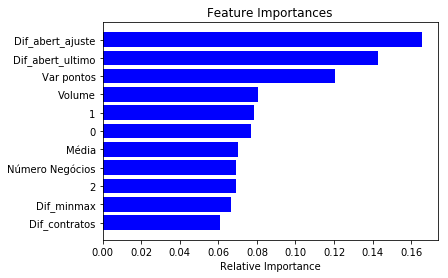

In [18]:
features = X_columns.columns
importances = r.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

W0912 18:31:57.806361  8952 deprecation_wrapper.py:119] From c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 18:31:58.089492  8952 deprecation_wrapper.py:119] From c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 18:31:58.092476  8952 deprecation_wrapper.py:119] From c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0912 18:31:58.138451  8952 deprecation_wrapper.py:119] From c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecat

Train on 3730 samples, validate on 415 samples
Epoch 1/200
3730/3730 [==============================] - 1s 149us/step - loss: 0.6710 - acc: 0.5995 - val_loss: 0.6548 - val_acc: 0.5880
Epoch 2/200
3730/3730 [==============================] - 0s 47us/step - loss: 0.6158 - acc: 0.6850 - val_loss: 0.5989 - val_acc: 0.6771
Epoch 3/200
3730/3730 [==============================] - 0s 56us/step - loss: 0.5693 - acc: 0.7177 - val_loss: 0.5581 - val_acc: 0.6964
Epoch 4/200
3730/3730 [==============================] - 0s 42us/step - loss: 0.5438 - acc: 0.7290 - val_loss: 0.5457 - val_acc: 0.7036
Epoch 5/200
3730/3730 [==============================] - 0s 50us/step - loss: 0.5343 - acc: 0.7311 - val_loss: 0.5394 - val_acc: 0.7036
Epoch 6/200
3730/3730 [==============================] - 0s 54us/step - loss: 0.5301 - acc: 0.7340 - val_loss: 0.5330 - val_acc: 0.7036
Epoch 7/200
3730/3730 [==============================] - 0s 46us/step - loss: 0.5277 - acc: 0.7362 - val_loss: 0.5281 - val_acc: 0.7036


3730/3730 [==============================] - 0s 43us/step - loss: 0.4979 - acc: 0.7466 - val_loss: 0.5018 - val_acc: 0.7422
Epoch 120/200
3730/3730 [==============================] - 0s 58us/step - loss: 0.4981 - acc: 0.7483 - val_loss: 0.5016 - val_acc: 0.7398
Epoch 121/200
3730/3730 [==============================] - 0s 53us/step - loss: 0.4977 - acc: 0.7469 - val_loss: 0.5013 - val_acc: 0.7373
Epoch 122/200
3730/3730 [==============================] - 0s 52us/step - loss: 0.4980 - acc: 0.7456 - val_loss: 0.5017 - val_acc: 0.7373
Epoch 123/200
3730/3730 [==============================] - 0s 60us/step - loss: 0.4976 - acc: 0.7464 - val_loss: 0.5016 - val_acc: 0.7470
Epoch 124/200
3730/3730 [==============================] - 0s 47us/step - loss: 0.4977 - acc: 0.7469 - val_loss: 0.5011 - val_acc: 0.7422
Epoch 125/200
3730/3730 [==============================] - 0s 45us/step - loss: 0.4970 - acc: 0.7450 - val_loss: 0.5012 - val_acc: 0.7422
Epoch 126/200
3730/3730 [=======================

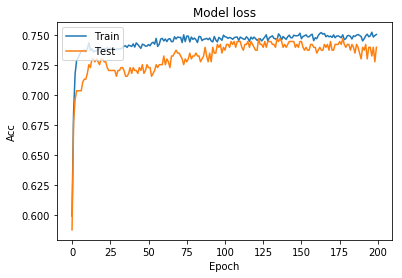

In [15]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=200, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(10, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=200, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=600, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(4, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=600, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(4, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=600, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()